# Auto Crop Model

### Import the libraries

In [30]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import json

### Verify the library versions

In [31]:
print('Numpy ' + np.__version__)
print('Tensorflow ' + tf.__version__)

Numpy 1.26.2
Tensorflow 2.15.0


### Model Parameters

In [32]:
tflite_model_name = 'auto_crop'

### Dataset Parameters

In [33]:
input_shape = (256, 192, 3)
n_samples = 170

### Create the dataset

In [34]:
image_dataset = []
anchor_dataset = []

for i in range(0, n_samples):
    # add images
    img = cv.imread(f'./dataset/images/{i}.png')
    image_dataset.append(img / 255)

    # add anchors
    with open(f'dataset/anchors/{i}.json', 'r') as file:
        data = json.load(file)
        anchor = data['shapes'][0]['points']
        anchor = np.array(anchor).astype(dtype=np.int32)
        anchor_map = np.zeros((input_shape[0], input_shape[1], 1), dtype=np.float32)

        cv.fillPoly(anchor_map, [anchor], color=1.0)

    anchor_dataset.append(anchor_map)

image_dataset = np.array(image_dataset, dtype=np.float32)
anchor_dataset = np.array(anchor_dataset, dtype=np.float32)

### Visualize output

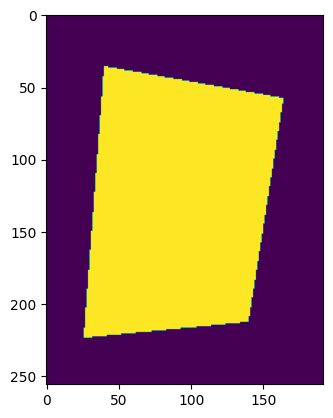

In [35]:
sample = plt.imshow(anchor_dataset[72])
plt.show()

### Create a model

In [36]:
model = keras.Sequential([
    keras.layers.Conv2D(64, 5, activation='relu', padding='same', input_shape=input_shape),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, 5, activation='relu', padding='same'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.UpSampling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.UpSampling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(64, 5, activation='relu', padding='same'),
    keras.layers.UpSampling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(64, 5, activation='relu', padding='same'),
    keras.layers.UpSampling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(1, 3, padding='same'),
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 256, 192, 64)      4864      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 128, 96, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 128, 96, 64)       102464    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 64, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 64, 48, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 32, 24, 128)      

In [37]:
history = model.fit(
                image_dataset[:128],
                anchor_dataset[:128],
                epochs=64,
                batch_size=32
)

Epoch 1/64


2023-12-15 22:17:43.695527: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/sequential_2/dropout_13/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 3s 184ms/step - loss: 0.8039 - accuracy: 0.6209
Epoch 2/64
4/4 [==============================] - 1s 180ms/step - loss: 0.8313 - accuracy: 0.6246
Epoch 3/64
4/4 [==============================] - 1s 183ms/step - loss: 0.6906 - accuracy: 0.6189
Epoch 4/64
4/4 [==============================] - 1s 180ms/step - loss: 0.6843 - accuracy: 0.6189
Epoch 5/64
4/4 [==============================] - 1s 179ms/step - loss: 0.6331 - accuracy: 0.6189
Epoch 6/64
4/4 [==============================] - 1s 178ms/step - loss: 0.4441 - accuracy: 0.6189
Epoch 7/64
4/4 [==============================] - 1s 178ms/step - loss: 0.4519 - accuracy: 0.6333
Epoch 8/64
4/4 [==============================] - 1s 176ms/step - loss: 0.3566 - accuracy: 0.8098
Epoch 9/64
4/4 [==============================] - 1s 176ms/step - loss: 0.2936 - accuracy: 0.8854
Epoch 10/64
4/4 [==============================] - 1s 177ms/step - loss: 0.2547 - accuracy: 0.8797
Epoch 11/64
4/4 [=============

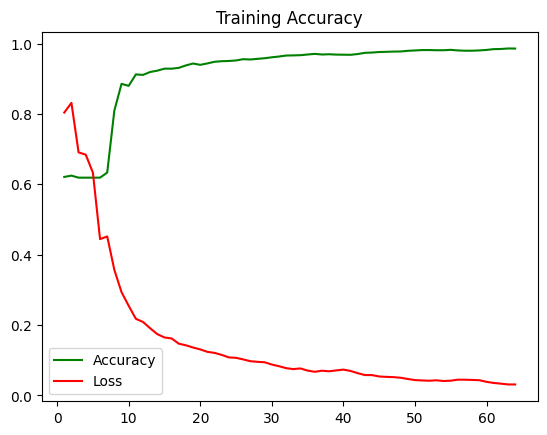

In [38]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Accuracy')
plt.plot(epochs, loss, 'r', label='Loss')
plt.title('Training Accuracy')
plt.legend()

### Export model to tflite

In [39]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpxx28kg30/assets


INFO:tensorflow:Assets written to: /tmp/tmpxx28kg30/assets
2023-12-15 22:18:32.678218: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-15 22:18:32.678245: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-15 22:18:32.678385: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpxx28kg30
2023-12-15 22:18:32.680551: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-15 22:18:32.680564: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpxx28kg30
2023-12-15 22:18:32.685711: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-15 22:18:32.762536: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpxx28kg30
2023-12-15 22:18:32.782335: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

7867228

### Test prediction

In [40]:
predictions = model.predict(image_dataset)

6/6 [==============================] - 0s 49ms/step


In [42]:
idx = 72

seg = predictions[idx] > 0.9
out = np.argwhere(seg)[:,:2]

def find_closest_coordinate(point, coordinates):
    distances = np.linalg.norm(coordinates - point, axis=1)
    closest_index = np.argmin(distances)
    return coordinates[closest_index][::-1]

top_left = find_closest_coordinate([0, 0], out)
top_right = find_closest_coordinate([0, 192 - 1], out)
bottom_left = find_closest_coordinate([256 - 1, 0], out)
bottom_right = find_closest_coordinate([256 - 1, 192 - 1], out)

anchor = np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)


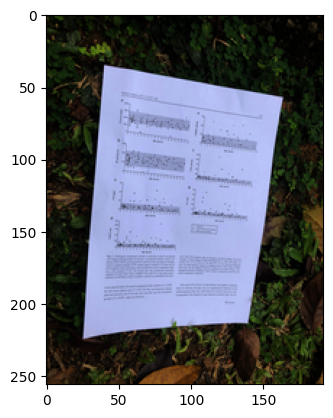

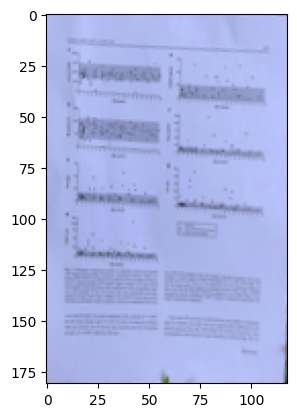

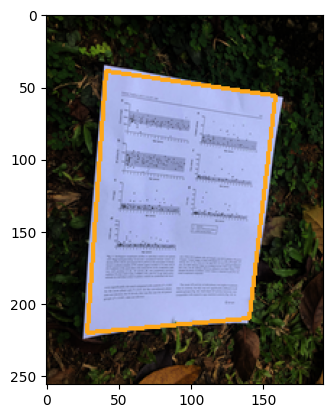

In [43]:
img = cv.imread(f'dataset/images/{idx}.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

sample = plt.imshow(img)
plt.show()

rect = anchor
tl, tr, br, bl = anchor

x1 = np.linalg.norm(br - bl)
x2 = np.linalg.norm(tr - tl)

y1 = np.linalg.norm(tr - br)
y2 = np.linalg.norm(tl - bl)

w = max(int(x1), int(x2))
h = max(int(y1), int(y2))

dst = np.array([
	[0, 0],
	[w - 1, 0],
	[w - 1, h - 1],
	[0, h - 1]], dtype = "float32")

M = cv.getPerspectiveTransform(rect, dst)
warp = cv.warpPerspective(img, M, (w, h))

sample = plt.imshow(warp)
plt.show()

tl, tr, br, bl = anchor.astype(dtype=np.int32)
cv.line(img, tl, tr, (254, 167, 24), 2)
cv.line(img, tr, br, (254, 167, 24), 2)
cv.line(img, br, bl, (254, 167, 24), 2)
cv.line(img, bl, tl, (254, 167, 24), 2)

sample = plt.imshow(img)
plt.show()